# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM,Bidirectional,GRU,Dropout, TextVectorization, Embedding, Input
from keras.regularizers import l2

# Importing the Dataset

In [2]:
filepath = r"/content/judge-1377884607_tweet_product_company.csv"

data = pd.read_csv(filepath,usecols=  ['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'], encoding='ISO 8859-1')

In [24]:
pd.set_option('display.max_colwidth', None)
data.sample(10)

,tweet,emotion
521,There's a free 22-song sampler available for download on iTunes of artists playing at #SXSW - check it out here {link} #music,No emotion toward brand or product
4960,At the Google party...awesome. #SXSW,Positive emotion
9041,"dear everyone coming to #SXSW, a friendly reminder that the iPad 2 comes out Friday and my birthday is Saturday. #justsayin",No emotion toward brand or product
4818,Big ups to @mention for his AWESOME #Austin for newbies map: {link} #SXSW,No emotion toward brand or product
8055,Come see something new about Google SketchUp Pro at #SXSW {link} via @mention Google SketchUp Blog,No emotion toward brand or product
2909,#SXSW friends - do u have an iPhone charger that @mention can borrow TONIGHT? cc: @mention @mention @mention @anniemal @maura,No emotion toward brand or product
3360,@mention great news for u and @mention and the TWiT crew. Apple is building a temporary Store for #SXSW 2011 so u can get ur ipad 2s !!,Positive emotion
4081,"This double buzzing issue with iPhone iOS 4.3 is getting annoying. In other news, an iPhone may fly across the room at #GR2L2 #SXSW",Negative emotion
2607,Test Drive an Xperia Play with @mention and @mention details here: {link} (at least some of them) #Android #sxsw,No emotion toward brand or product
4671,I'm listening to 'Get By' by Talib Kweli via the Discovr app on my iPhone while I'm on a plane to #sxsw. Love Gogo. {link},Positive emotion


# Preprocessing

In [4]:
data.shape

(9093, 2)

In [5]:
data.columns = ['tweet', 'emotion']

data.head()

,tweet,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9092 non-null   object
 1   emotion  9093 non-null   object
dtypes: object(2)
memory usage: 142.2+ KB


In [7]:
data.isna().sum()

,0
tweet,1
emotion,0


In [8]:
print(data[data['tweet'].isna() == True])

data = data.dropna(ignore_index=True)

data[0:10]

  tweet                             emotion
6   NaN  No emotion toward brand or product


,tweet,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Positive emotion


In [9]:
# Converting to string

data = data.astype('string')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9092 non-null   string
 1   emotion  9092 non-null   string
dtypes: string(2)
memory usage: 142.2 KB


In [25]:
data['emotion'].value_counts()  #Highly imbalanced classes - Most of the tweets are of neutral  tone.

,count
emotion,
No emotion toward brand or product,5388
Positive emotion,2978
Negative emotion,570
I can't tell,156


In [10]:
classes= pd.get_dummies(data['emotion'],dtype='int')
classes

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,0,1,0,0
1,0,0,0,1
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1
...,...,...,...,...
9087,0,0,0,1
9088,0,0,1,0
9089,0,0,1,0
9090,0,0,1,0


In [11]:
classes.columns = ['no_idea', 'negative', 'neutral','positive']
classes.head()

,no_idea,negative,neutral,positive
0,0,1,0,0
1,0,0,0,1
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1


# Train_test_split

In [12]:
x_train , x_test, y_train, y_test = train_test_split(data['tweet'],classes,test_size = 0.1 , random_state =0 , stratify=classes )

In [13]:
x_test

,tweet
1142,ÛÏ@mention The 10 most dangerous IPhone apps....
4294,Bah! I somehow lost my little @mention iPad wi...
2720,Temp Apple store in Austin has quite a few #iP...
1602,True. RT @mention I bet the longest iPad lines...
8228,I can just feel the buzz!RT @mention Google to...
...,...
271,Surprise! Apple has opened a pop-up store in A...
2132,The line at 6th &amp; Congress to enter the ne...
2712,Get in the season with Clover Touch: {link} #G...
5535,RT @mention Awesome new version of @mention fo...


# Text Vectorization

In [14]:
vectorizer = TextVectorization(max_tokens=5000)
vectorizer.adapt(x_train)

# Simple RNN

In [19]:
model = Sequential()

model.add(vectorizer)
model.add(Embedding(input_dim= 5000, output_dim=256,mask_zero=True))
model.add(SimpleRNN(128,activation='tanh',return_sequences = True))
model.add(SimpleRNN(64))

model.add(Dense(64,activation='tanh'))
model.add(Dense(4,activation='softmax'))

In [20]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [21]:
history = model.fit(x_train,y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (x_test,y_test))

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.5678 - loss: 0.9636 - val_accuracy: 0.6088 - val_loss: 0.8740
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.7266 - loss: 0.6698 - val_accuracy: 0.6055 - val_loss: 0.9049
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.8451 - loss: 0.4206 - val_accuracy: 0.6242 - val_loss: 0.9995
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.8993 - loss: 0.2747 - val_accuracy: 0.6198 - val_loss: 1.1261
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.9141 - loss: 0.2098 - val_accuracy: 0.6077 - val_loss: 1.2657
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.9265 - loss: 0.1788 - val_accuracy: 0.5703 - val_loss: 1.5083
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9332 - loss: 0.1510 - val_accuracy: 0.6220 - val_loss: 1.5783
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.9320 - loss: 0.1457 -

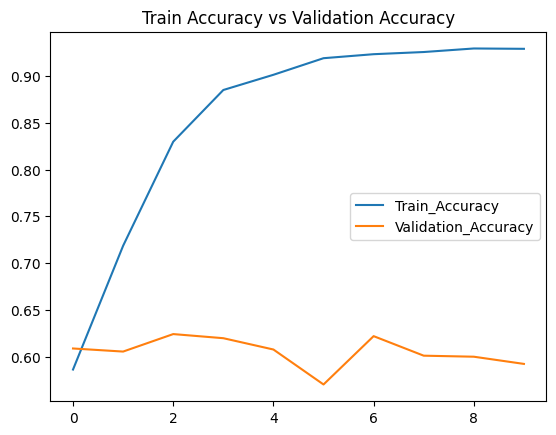

In [23]:
plt.plot(history.history['accuracy'], label = 'Train_Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation_Accuracy')
plt.legend()
plt.title("Train Accuracy vs Validation Accuracy")
plt.show()

The model is ,likely overfitting, trying LSTM on the data with preventing overfitting using regularizers

# LSTM

In [31]:
model_1 = Sequential()

model_1.add(vectorizer)
model_1.add(Embedding(input_dim=5000, output_dim=256,mask_zero=True))

model_1.add(LSTM(256,activation='tanh',return_sequences = True, kernel_regularizer=l2(0.02)))
model_1.add(LSTM(256,activation='tanh',return_sequences = True, kernel_regularizer=l2(0.02)))
model_1.add(LSTM(64, return_sequences = True, kernel_regularizer=l2(0.02)))
model_1.add(LSTM(32))


model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(4,activation='softmax'))

#Compiling model_1
model_1.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [32]:
history_1 = model_1.fit(x_train,y_train,
                        epochs = 10,
                        batch_size = 8,
                        validation_data = (x_test,y_test))

Epoch 1/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5759 - loss: 3.0384 - val_accuracy: 0.5923 - val_loss: 0.9206
Epoch 2/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5931 - loss: 0.9803 - val_accuracy: 0.5923 - val_loss: 0.9255
Epoch 3/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5937 - loss: 0.9233 - val_accuracy: 0.5923 - val_loss: 0.9223
Epoch 4/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5875 - loss: 0.9355 - val_accuracy: 0.5923 - val_loss: 0.9231
Epoch 5/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5978 - loss: 0.9219 - val_accuracy: 0.5923 - val_loss: 0.9225
Epoch 6/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5965 - loss: 0.9287 - val_accuracy: 0.5923 - val_loss: 0.9216
Epoch 7/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5934 - loss: 0.9187 - val_accuracy: 0.5923 - val_loss: 0.9235
Epoch 8/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5909 -

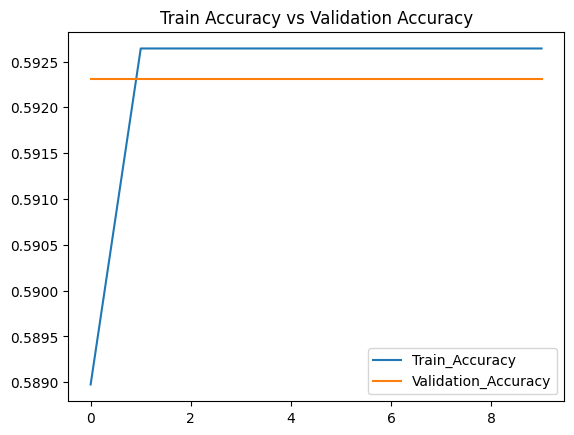

In [30]:
plt.plot(history_1.history['accuracy'], label = 'Train_Accuracy')
plt.plot(history_1.history['val_accuracy'], label = 'Validation_Accuracy')
plt.legend()
plt.title("Train Accuracy vs Validation Accuracy")
plt.show()

The overfitting issue has been resolved.
But even after much fine tuning, the model is not learning anything, -- trying other models to see if the issue persists.

# GRU and Bidirectional

In [33]:
model_2 = Sequential()

model_2.add(vectorizer)
model_2.add(Embedding(input_dim=5000, output_dim= 256,mask_zero=True))

model_2.add(Bidirectional(GRU(128, return_sequences = True, kernel_regularizer=l2(0.05))))
model_2.add(Bidirectional(GRU(128, return_sequences = True, kernel_regularizer=l2(0.05))))
model_2.add(GRU(32, kernel_regularizer=l2(0.05)))

model_2.add(Dense(64,activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(4,activation='softmax'))

#Compiling model_2
model_2.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [34]:
history_2 =model_2.fit(x_train,y_train,
                      epochs = 10,
                      validation_data = (x_test,y_test))

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.5773 - loss: 22.5810 - val_accuracy: 0.5923 - val_loss: 0.9312
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5841 - loss: 0.9487 - val_accuracy: 0.5923 - val_loss: 0.9254
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5963 - loss: 0.9237 - val_accuracy: 0.5923 - val_loss: 0.9219
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5992 - loss: 0.9262 - val_accuracy: 0.5923 - val_loss: 0.9239
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5971 - loss: 0.9146 - val_accuracy: 0.5923 - val_loss: 0.9207
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5968 - loss: 0.9166 - val_accuracy: 0.5923 - val_loss: 0.9226
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5938 - loss: 0.9202 - val_accuracy: 0.5923 - val_loss: 0.9207
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5807 - loss: 0.9333 - val_ac

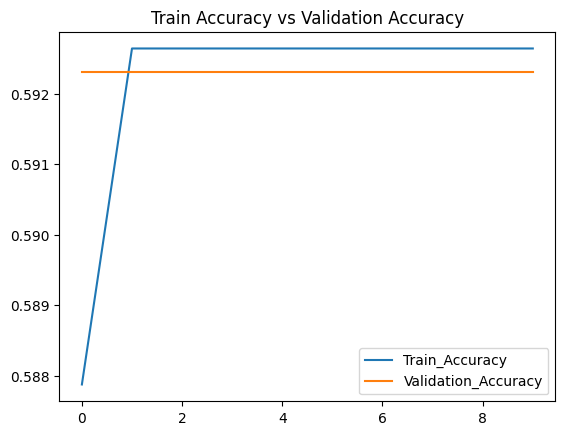

In [35]:
plt.plot(history_2.history['accuracy'], label = 'Train_Accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'Validation_Accuracy')
plt.legend()
plt.title("Train Accuracy vs Validation Accuracy")
plt.show()

# Custom Model with multiple Layers

In [41]:
model_3 = Sequential()

model_3.add(vectorizer)
model_3.add(Embedding(input_dim=5000, output_dim= 512,mask_zero=True))

model_3.add(tf.keras.layers.Conv1D(kernel_size = 3, filters= 64))
model_3.add(Bidirectional(GRU(128, return_sequences = True, kernel_regularizer=l2(0.02))))
model_3.add(Bidirectional(GRU(128, return_sequences = True, kernel_regularizer=l2(0.02))))
model_3.add(LSTM(32))

model_3.add(Dense(16,activation='tanh'))
model_3.add(Dense(4,activation='softmax'))

#Compiling model_3
model_3.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [42]:
history_3 =model_3.fit(x_train,y_train,
                      epochs = 15,
                      batch_size = 16,
                      validation_data = (x_test,y_test))

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5644 - loss: 4.3093

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


512/512 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.5645 - loss: 4.3046 - val_accuracy: 0.5923 - val_loss: 0.9235
Epoch 2/15
512/512 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5939 - loss: 0.9249 - val_accuracy: 0.5923 - val_loss: 0.9257
Epoch 3/15
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5944 - loss: 0.9154 - val_accuracy: 0.5923 - val_loss: 0.9247
Epoch 4/15
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5974 - loss: 0.9112 - val_accuracy: 0.5923 - val_loss: 0.9247
Epoch 5/15
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5910 - loss: 0.9216 - val_accuracy: 0.5923 - val_loss: 0.9211
Epoch 6/15
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5947 - loss: 0.9083 - val_accuracy: 0.5923 - val_loss: 0.9229
Epoch 7/15
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5948 - loss: 0.9201 - val_accuracy: 0.5923 - val_loss: 0.9209
Epoch 8/15
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5966 - loss: 0.9103 - val_accuracy:

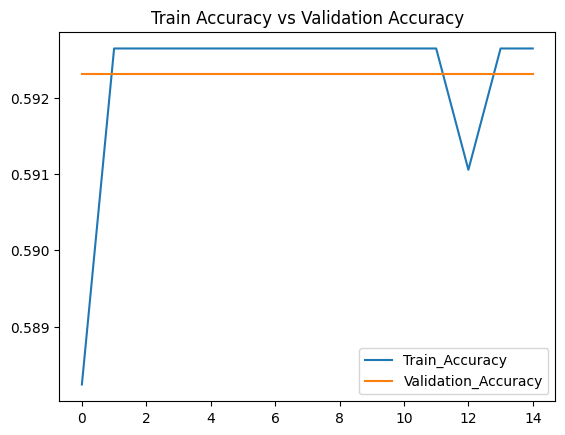

In [43]:
plt.plot(history_3.history['accuracy'], label = 'Train_Accuracy')
plt.plot(history_3.history['val_accuracy'], label = 'Validation_Accuracy')
plt.legend()
plt.title("Train Accuracy vs Validation Accuracy")
plt.show()

Even after trying out different models with different layers and parameters, there is no improvement in accuracy + The data has a very highly imbalanced classes   -- indicating that the data may be not sufficient for the models to learn.